# Multilayer Perceptron (MLP) for generating Onion-like News Headlines

Based on Andrej Karpathy's Youtube lecture [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I) and Bengio et al's paper [A Neural Probabilistic Langue Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, random
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F
import torch.nn as nn

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

seed = 2468975301

In [2]:
use_gpu = lambda gpu: 'cuda' if gpu else 'cpu'
device = use_gpu(False)

In [3]:
onion_df = pd.read_csv('../../data/cleaned_onion_headlines.csv')

texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
vocab_size = len(vocab)
vocab_size

28

## Functions

In [4]:
def build_dataset(texts, stoi, block_size=3):
  X,Y = [],[]

  for text in texts:
    context = [0] * block_size
    for ch in text:
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]

  return torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [5]:
def split_datasets(X, Y, train_pct=0.8, dev_pct=0.1, device='cpu'):
  X = X.to(device)
  Y = Y.to(device)
  r = np.random.RandomState(seed)
  idxs = np.arange(len(X))
  r.shuffle(idxs) 

  n1 = int(train_pct*len(idxs))
  n2 = int((train_pct+dev_pct)*len(idxs))  

  return X[idxs[:n1]],Y[idxs[:n1]],X[idxs[n1:n2]],Y[idxs[n1:n2]],X[idxs[n2:]],Y[idxs[n2:]]

## MLP

In [6]:
X,Y = build_dataset(texts, stoi)
X_train,Y_train,X_dev,Y_dev,X_test,Y_test = split_datasets(X,Y, device=device)

In [7]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
emb_size = 10
hidden_dim = 200
input_dim = block_size * emb_size

In [8]:
g = torch.Generator(device=device).manual_seed(seed)
X = X.to(device=device)
Y = Y.to(device=device)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]
n_params = sum([p.nelement() for p in params])
n_params

12108

In [10]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch SGD
  idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
  Xb,Yb = X_train[idx],Y_train[idx]
  
  # forward pass
  emb = C[Xb]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb) 
  
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():0.4f}")
  lossi.append(loss.log10().item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in params:
    p.data += -lr * p.grad

print(loss.item())    

      0/ 200000: 31.8698
  10000/ 200000: 2.2822
  20000/ 200000: 2.6082
  30000/ 200000: 2.8371
  40000/ 200000: 1.8822
  50000/ 200000: 2.3367
  60000/ 200000: 1.9050
  70000/ 200000: 2.6512
  80000/ 200000: 1.9862
  90000/ 200000: 2.1670
 100000/ 200000: 2.5422
 110000/ 200000: 1.8976
 120000/ 200000: 1.4270
 130000/ 200000: 2.1450
 140000/ 200000: 1.7728
 150000/ 200000: 1.7565
 160000/ 200000: 1.8069
 170000/ 200000: 2.2099
 180000/ 200000: 2.1655
 190000/ 200000: 1.8235
1.6145991086959839
CPU times: user 10min 37s, sys: 496 ms, total: 10min 37s
Wall time: 1min 20s


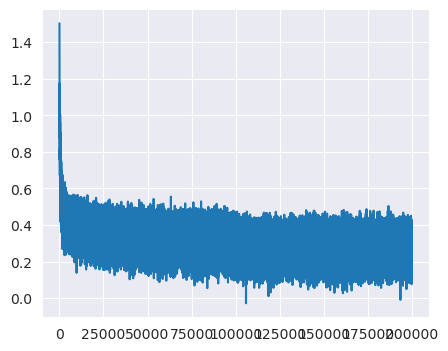

In [12]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
ax.plot(lossi)

In [13]:
@torch.no_grad() # decorator to disable gradient tracking
def calc_loss(X, y):
  emb = C[X] # (N, block_size, emb_size)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * emb_size)
  h = torch.tanh(embcat @ W1 + b1) # (N, hidden_dim)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  return loss.item()

In [14]:
calc_loss(X_train, Y_train)

1.897980809211731

In [15]:
calc_loss(X_dev, Y_dev)

1.9135493040084839

In [16]:
calc_loss(X_test, Y_test)

1.9111653566360474

## Building the network

1. Let's build the table look-up `C` from the paper. In the paper, their vocab is 17K words with a 30-dim embedding. We have 28 characters, so we'll start with embedding them into 2 dimensions.
2. Lookup table is the *same* as matrix multiplication with one-hot enc.
3. Pytorch indexing with tensors with example C[X][13,2]



In [ ]:
emb_size = 2
hidden_dim = 100
input_dim = block_size * emb_size

In [ ]:
C = torch.randn((vocab_size, emb_size), device=device)
C.shape

In [ ]:
emb = C[X]
emb.shape

In [ ]:
W1 = torch.randn(input_dim, hidden_dim)
b1 = torch.randn(hidden_dim)

Best way to transform tensors `view`

In [ ]:
h = emb.view(-1, input_dim) @ W1 + b1
h.shape

In [ ]:
W2 = torch.randn((hidden_dim, vocab_size), device=device)
b2 = torch.randn(vocab_size, device=device)

In [ ]:
logits = h @ W2 + b2
logits.shape

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
g = torch.Generator(device=device).manual_seed(seed)
X = X.to(device=device)
Y = Y.to(device=device)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]
n_params = sum([p.nelement() for p in params])
n_params

In [ ]:
batch_size = 32

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

1. So low loss because of single data point of 62 examples! 3584 params for 62 examples = overfitting single batch
2. minibatch SGD
3. Cuda
4. Learning rate determiner
5. Learning rate plateau

In [ ]:
%%time

lri = []
lossi = []

for i in range(10000):
  # minibatch SGD
  idx = torch.randint(0, len(X), (batch_size, ))
  # forward pass
  emb = C[X[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[idx])  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = lrs[i]
  lr = 10**-0.8
  for p in params:
    p.data += -lr * p.grad
    
  # lri.append(lre[i])
  # lossi.append(loss.item())
    
print(loss.item())    

In [ ]:
  emb = C[X]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)  
  print(f'{loss.item():0.4f}')

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(10, 8))
# ax.plot(lri, lossi)

## Dataset Splits

In [ ]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
emb_size = 2
hidden_dim = 100
input_dim = block_size * emb_size
batch_size = 4096
log_lossi = []

X,Y = build_dataset(texts, stoi)

In [ ]:
device = use_gpu(True)

In [ ]:
X_train,Y_train,X_dev,Y_dev,X_test,Y_test = split_datasets(X,Y, device=device)

g = torch.Generator(device=device).manual_seed(seed)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]

n_params = sum([p.nelement() for p in params])
print(f"Number of params: {n_params}")
print(f"Training set size: {X_train.nelement()}")
print(f"Dev set size: {X_dev.nelement()}")
print(f"Test set size: {X_dev.nelement()}")

In [ ]:
%%time
for i in range(100000):
  idx = torch.randint(0, len(X_train), (batch_size, ))
  
  # forward pass
  emb = C[X_train[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[idx])
  if i % 10000 == 0:
    print(f"Iteration: {i}, Loss: {loss.item():0.4f}")  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = 10**-1.4
  lr = 10**-0.8 if i < 80000 else 10**-1.4
  for p in params:
    p.data += -lr * p.grad
    
  log_lossi.append(loss.log10().item())

# print(f'Training Loss: {loss.item():0.4f}')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.plot(range(len(log_lossi)), log_lossi)

In [ ]:
X_train,Y_train,X_dev,Y_dev = X_train.cpu(),Y_train.cpu(),X_dev.cpu(),Y_dev.cpu()
C,W1,b1,W2,b2 = C.cpu(),W1.cpu(),b1.cpu(),W2.cpu(),b2.cpu()

In [ ]:
  emb = C[X_train]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train)  
  print(f'Training Loss: {loss.item():0.4f}')

In [ ]:
  emb = C[X_dev]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_dev)  
  print(f'Dev Loss: {loss.item():0.4f}')

In [ ]:
X_test,Y_test = X_test.cpu(),Y_test.cpu()

emb = C[X_test]
h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)  
print(f'Test Loss: {loss.item():0.4f}')

## Plot the embedding

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  ax.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
  ax.grid('minor')

## Sample from the model

In [ ]:
g = torch.Generator().manual_seed(seed)
n_headlines = 20
for _ in range(n_headlines):  
  ai_onion = []
  context = [0] * block_size # initialize with all ###
  while True:
    emb = C[torch.tensor([context])] # (1, block_size)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [idx]
    ai_onion.append(itos[idx])
    if idx == 0 or len(ai_onion) > np.random.randint(300, 600):
      break
  print(''.join(ai_onion[:-1]))